In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings



# Load data
df = pd.read_csv('eia_monthly_data.csv')
df['period'] = pd.to_datetime(df['period'])
df.set_index('period', inplace=True)
df.sort_index(inplace=True)

# Filter for Nuclear
wind_df = df[df['fuelTypeDescription'] == 'wind'].copy()
print("Wind Data Loaded:")
print(wind_df.head())

Wind Data Loaded:
           fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
period                                                              
2001-01-01        WND                wind                 0.86726   
2001-02-01        WND                wind                 1.46364   
2001-03-01        WND                wind                 0.90549   
2001-04-01        WND                wind                 1.19333   
2001-05-01        WND                wind                 1.06752   

            consumption-uto-btu  cost-per-btu  generation  heat-content  \
period                                                                    
2001-01-01                  0.0           NaN      83.931           NaN   
2001-02-01                  0.0           NaN     141.647           NaN   
2001-03-01                  0.0           NaN      87.631           NaN   
2001-04-01                  0.0           NaN     115.487           NaN   
2001-05-01                  0.0           NaN   

In [42]:
def model_sarimax_exog(train_data, exog_train, exog_future, horizon):
    """
    SARIMAX that uses an exogenous variable (predictor).
    """
    # Ensure indices align for safety
    if len(train_data) != len(exog_train):
        raise ValueError("Train data and Exog train data must be same length")
        
    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=(1, 0, 0),              # Adjusted for Solar (Trend usually captured by Exog)
        seasonal_order=(1, 1, 0, 12), # Strong yearly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    # We must provide the future values of the predictor (exog) to forecast
    forecast = res.get_forecast(steps=horizon, exog=exog_future)
    predicted_mean = forecast.predicted_mean
    
    # Safety Check: If index is not dates, fix it
    if not isinstance(predicted_mean.index, pd.DatetimeIndex):
         last_date = train_data.index[-1]
         forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1), 
            periods=horizon, 
            freq='MS'
        )
         predicted_mean = pd.Series(predicted_mean.values, index=forecast_dates)
         
    return predicted_mean

def run_backtest_with_exog(target_series, predictor_series, model_function, train_window, horizon, step):
    """
    Rolls through the data, applying the model with a predictor at every step.
    
    Args:
        target_series: The variable to predict (e.g., Solar Production)
        predictor_series: The leading variable (e.g., Installed Capacity)
        ...
    """
    results = []
    total_len = len(target_series)
    start_idx = 0
    
    print(f"   > Running backtest on {target_series.name} using {predictor_series.name} as predictor...")
    
    while True:
        end_train_idx = start_idx + train_window
        end_forecast_idx = end_train_idx + horizon
        
        # Stop if we don't have enough data for a full forecast + validation
        # (We need the future predictor values to exist to make a forecast)
        if end_forecast_idx > total_len:
            break
            
        # 1. Slice Targets
        train_target = target_series.iloc[start_idx : end_train_idx]
        
        # 2. Slice Predictors
        # Part A: The history used to train the relationship
        train_predictor = predictor_series.iloc[start_idx : end_train_idx]
        
        # Part B: The "Future" values used to generate the prediction
        # (In a real scenario, this would be your estimated future capacity)
        future_predictor = predictor_series.iloc[end_train_idx : end_forecast_idx]
        
        # 3. Predict
        try:
            forecast_series = model_function(
                train_target, 
                train_predictor, 
                future_predictor, 
                horizon
            )
            
            results.append({
                'cutoff_date': train_target.index[-1],
                'forecast': forecast_series,
                'actuals': target_series # Store full ref
            })
            
        except Exception as e:
            print(f"     ! Model failed at {train_target.index[-1]}: {e}")

        # 4. Step
        start_idx += step


def evaluate_and_plot(ax, sector_name, results):

    """
    Plots forecasts vs actuals and calculates simple error metrics.
    """
    if not results:
        return

    # Extract full actual series from the first result for plotting context
    actual_series = results[0]['actuals']
    
    # Plot Actuals
    ax.plot(actual_series.index, actual_series, color='green', linewidth=2, label='Actual Data', zorder=1)
    
    errors = []
    
    # Plot Forecasts
    first_fc = True
    for item in results:
        fc = item['forecast']
        cutoff = item['cutoff_date']
        
        # Calculate Error (RMSE) for this specific window
        # We only compare where indices overlap
        common_idx = fc.index.intersection(actual_series.index)
        if not common_idx.empty:
            rmse = np.sqrt(mean_squared_error(actual_series[common_idx], fc[common_idx]))
            errors.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index, fc, color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        ax.scatter(cutoff, actual_series[cutoff], color='black', s=20, zorder=3)
        first_fc = False

    # Calculate Average Error
    avg_rmse = np.mean(errors) if errors else 0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse

def get_prediction_diffs(results, sector_name):
    """
    Extracts row-by-row differences for every prediction made.
    Returns: DataFrame columns ['Sector', 'Cutoff_Date', 'Pred_Date', 'Predicted', 'Actual', 'Diff']
    """
    diff_data = []
    
    # We need the full actuals to look up the 'truth' for every forecast date
    if not results:
        return pd.DataFrame()
        
    actuals_series = results[0]['actuals']
    
    for item in results:
        cutoff = item['cutoff_date']
        forecast_series = item['forecast']
        
        # Iterate through every month in this specific forecast window
        for pred_date, pred_value in forecast_series.items():
            
            # Check if we actually have the truth for this date yet
            if pred_date in actuals_series.index:
                actual_value = actuals_series.loc[pred_date]
                diff = pred_value - actual_value
                
                diff_data.append({
                    'Sector': sector_name,
                    'Cutoff_Date': cutoff,        # When we made the guess
                    'Prediction_Date': pred_date, # The date we guessed for
                    'Predicted': pred_value,
                    'Actual': actual_value,
                    'Difference': diff            # (Predicted - Actual)
                })
    
    return pd.DataFrame(diff_data)

In [43]:
wind_capacity = pd.read_excel('eia8602024_1/3_1_Generator_Y2024.xlsx', engine="openpyxl")


In [44]:
new_header = wind_capacity.iloc[0] #grab the first row for the header
wind_capacity_final = wind_capacity[1:] #take the data less the header row
wind_capacity_final.columns = new_header #set the header row as the df header

wind_capacity_final = wind_capacity_final[wind_capacity_final['State'] == 'TX']
wind_capacity_final = wind_capacity_final[wind_capacity_final['Technology']=='Onshore Wind Turbine']

wind_capacity_final = wind_capacity_final[['Operating Month', 'Operating Year', 'Nameplate Capacity (MW)']]
wind_capacity_final = wind_capacity_final.groupby(['Operating Year', 'Operating Month'])['Nameplate Capacity (MW)'].sum()


wind_capacity_final.index = pd.to_datetime([f'{m}-01-{y}' for y, m in wind_capacity_final.index])
wind_capacity_df = pd.DataFrame(wind_capacity_final)
wind_capacity_df = wind_capacity_df.sort_index()

wind_capacity_df['cumulative_wind_capacity'] = wind_capacity_df['Nameplate Capacity (MW)'].cumsum()


predictor_series = wind_capacity_df['cumulative_wind_capacity']
# Create a complete monthly date range
full_date_range = pd.date_range(start='2010-11-01', end='2024-12-01', freq='MS')

# Reindex the series to include all months and forward fill missing values
predictor_series = predictor_series.reindex(full_date_range).ffill()

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35662/2698274019.py:24: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [45]:
solar_proposed = pd.read_excel('eia8602024_1/3_1_Generator_Y2024.xlsx', sheet_name='Proposed')


new_header = solar_proposed.iloc[0] #grab the first row for the header
solar_proposed = solar_proposed[1:] #take the data less the header row
solar_proposed.columns = new_header #set the header row as the df header

solar_proposed_final = solar_proposed[solar_proposed['State'] == 'TX']
solar_proposed_final = solar_proposed_final[solar_proposed_final['Technology']=='Onshore Wind Turbine']



solar_proposed_final = solar_proposed_final[['Current Month', 'Current Year', 'Nameplate Capacity (MW)']]
solar_proposed_final = solar_proposed_final.groupby(['Current Month', 'Current Year'])['Nameplate Capacity (MW)'].sum()


solar_proposed_final.index = pd.to_datetime([f'{m}-01-{y}' for y, m in solar_proposed_final.index])
solar_proposed_df = pd.DataFrame(solar_proposed_final)

solar_proposed_df = solar_proposed_df.sort_index()
solar_proposed_df['cumulative_wind_capacity'] = solar_proposed_df['Nameplate Capacity (MW)'].cumsum()

capacity_series = solar_proposed_df['cumulative_wind_capacity']
capacity_series.index = pd.to_datetime(capacity_series.index)

full_idx = pd.date_range('2025-01-01', '2030-06-01', freq='MS')

capacity_series = capacity_series.reindex(full_idx).ffill()

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35662/435603564.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [46]:
capacity_series

2025-01-01     503.5
2025-02-01     503.5
2025-03-01     503.5
2025-04-01     503.5
2025-05-01     503.5
               ...  
2030-02-01    3709.5
2030-03-01    3709.5
2030-04-01    3709.5
2030-05-01    3709.5
2030-06-01    3709.5
Freq: MS, Name: cumulative_wind_capacity, Length: 66, dtype: float64

In [47]:
predictor_series

2010-11-01        NaN
2010-12-01     9921.5
2011-01-01     9921.5
2011-02-01     9921.5
2011-03-01     9921.5
               ...   
2024-08-01    42082.3
2024-09-01    42082.3
2024-10-01    42082.3
2024-11-01    42082.3
2024-12-01    42282.9
Freq: MS, Name: cumulative_wind_capacity, Length: 170, dtype: float64

In [48]:
capacity_series = capacity_series + predictor_series[-1]

/var/folders/mt/pdjyzsld07d3bsb5b0j5lvp00000gn/T/ipykernel_35662/2952279624.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [49]:
predictor_series

2010-11-01        NaN
2010-12-01     9921.5
2011-01-01     9921.5
2011-02-01     9921.5
2011-03-01     9921.5
               ...   
2024-08-01    42082.3
2024-09-01    42082.3
2024-10-01    42082.3
2024-11-01    42082.3
2024-12-01    42282.9
Freq: MS, Name: cumulative_wind_capacity, Length: 170, dtype: float64

In [50]:
capacity_series

2025-01-01    42786.4
2025-02-01    42786.4
2025-03-01    42786.4
2025-04-01    42786.4
2025-05-01    42786.4
               ...   
2030-02-01    45992.4
2030-03-01    45992.4
2030-04-01    45992.4
2030-05-01    45992.4
2030-06-01    45992.4
Freq: MS, Name: cumulative_wind_capacity, Length: 66, dtype: float64

In [51]:
wind_capacity = pd.concat([predictor_series, capacity_series])

In [52]:
wind_capacity

2010-11-01        NaN
2010-12-01     9921.5
2011-01-01     9921.5
2011-02-01     9921.5
2011-03-01     9921.5
               ...   
2030-02-01    45992.4
2030-03-01    45992.4
2030-04-01    45992.4
2030-05-01    45992.4
2030-06-01    45992.4
Freq: MS, Name: cumulative_wind_capacity, Length: 236, dtype: float64

In [53]:
target_series = wind_df['generation'].dropna()
target_series = target_series[target_series > 0]
target_series = target_series[target_series.index > '2010-11-01']


In [54]:
target_series

period
2010-12-01     2594.58814
2011-01-01     2063.69265
2011-02-01     2528.33791
2011-03-01     2688.71479
2011-04-01     3066.34696
                 ...     
2025-05-01    10532.07182
2025-06-01    11575.31250
2025-07-01    10547.11416
2025-08-01     8277.87363
2025-09-01     7569.51448
Name: generation, Length: 178, dtype: float64

In [55]:
wind_capacity.dropna(inplace=True)

In [56]:
def model_sarimax_exog(train_data, exog_train, exog_future, horizon):

    train_data = train_data.astype(float)
    exog_train = exog_train.astype(float)
    exog_future = exog_future.astype(float)

    if len(train_data) != len(exog_train):
        common_idx = train_data.index.intersection(exog_train.index)
        train_data = train_data.loc[common_idx]
        exog_train = exog_train.loc[common_idx]
    
    if train_data.index.freq is None:
        try:
            train_data.index.freq = pd.infer_freq(train_data.index)
            if train_data.index.freq is None:
                train_data = train_data.asfreq('MS')
                exog_train = exog_train.asfreq('MS')
        except:
            pass

    model = SARIMAX(
        train_data,
        exog=exog_train,
        order=(1, 0, 0),              
        seasonal_order=(1, 1, 0, 12), 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    
    # Forecast
    forecast = res.get_forecast(steps=horizon, exog=exog_future)
    predicted_mean = forecast.predicted_mean
    
    # Ensure index is Datetime
    if not isinstance(predicted_mean.index, pd.DatetimeIndex):
         last_date = train_data.index[-1]
         forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1), 
            periods=horizon, 
            freq='MS'
        )
         predicted_mean = pd.Series(predicted_mean.values, index=forecast_dates)
         
    return predicted_mean


def run_backtest_with_exog(target_series, predictor_series, model_function, train_window, horizon, step):

    results = []

    aligned_target = target_series
    aligned_predictor = predictor_series
    total_len = len(aligned_predictor)
    
    start_idx = 0
    
    while True:
        end_train_idx = start_idx + train_window
        end_forecast_idx = end_train_idx + horizon
        
        if end_forecast_idx > total_len:
            break
            
        train_target = aligned_target.iloc[start_idx : end_train_idx]
        train_predictor = aligned_predictor.iloc[start_idx : end_train_idx]
        future_predictor = aligned_predictor.iloc[end_train_idx : end_forecast_idx]
        
        try:
            forecast_series = model_function(
                train_target, 
                train_predictor, 
                future_predictor, 
                horizon
            )
            
            results.append({
                'cutoff_date': train_target.index[-1],
                'forecast': forecast_series,
                'actuals': aligned_target # Full aligned actuals for context
            })
            
        except Exception as e:
            print(f"     ! Model failed at {train_target.index[-1]}: {e}")

        # Step
        start_idx += step
        
    return results


def get_prediction_diffs(results_list, sector_name):

    all_dfs = []
    
    if not results_list:
        return None
    
    for res in results_list:
        cutoff = res['cutoff_date']
        fc = res['forecast']
        actuals = res['actuals']
        
        common_idx = fc.index.intersection(actuals.index)
        
        if common_idx.empty:
            continue
            
        diffs = fc[common_idx] - actuals[common_idx]
        
        window_df = pd.DataFrame({
            'Sector': sector_name,
            'Cutoff_Date': cutoff,
            'Prediction_Date': common_idx,
            'Predicted': fc[common_idx],
            'Actual': actuals[common_idx],
            'Error_Diff': diffs,
            'Abs_Error': diffs.abs()
        })
        all_dfs.append(window_df)
            
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

def evaluate_and_plot(ax, sector_name, results_list):



    full_actuals = results_list[0]['actuals']
    ax.plot(full_actuals.index, full_actuals, color='green', label='Actuals', linewidth=2, zorder=1)
    
    rmse_scores = []
    
    first_fc = True
    for res in results_list:
        fc = res['forecast']
        cutoff = res['cutoff_date']
        
        match_act = res['actuals'].reindex(fc.index)
        valid_idx = match_act.dropna().index
        
        if len(valid_idx) > 0:
            rmse = np.sqrt(mean_squared_error(match_act.loc[valid_idx], fc.loc[valid_idx]))
            rmse_scores.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index, fc, color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        ax.scatter(cutoff, full_actuals.get(cutoff), color='black', s=25, zorder=3)
        first_fc = False
    
    avg_rmse = np.mean(rmse_scores) if rmse_scores else 0.0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse


CHOSEN_MODEL = model_sarimax_exog 
TRAIN_WINDOW = 60
FORECAST_HORIZON = 24
STEP_SIZE = 24

results = run_backtest_with_exog(
    target_series, 
    wind_capacity,
    CHOSEN_MODEL, 
    TRAIN_WINDOW, 
    FORECAST_HORIZON, 
    STEP_SIZE
)


BUG. THE MONTH DATES I PUT IN ARE STATIC. HOWEVER I KEEP PULLING THE DATA SO I HAVE TO FIX THIS STATICNESS

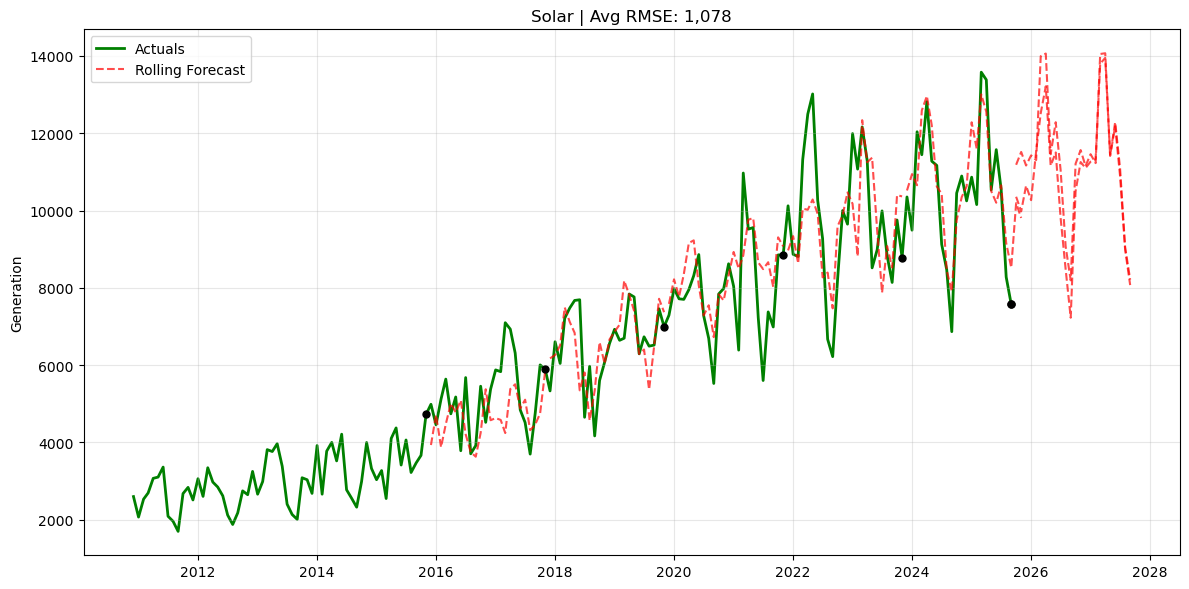


Final Result -> Average RMSE: 1,078.25

Sample Errors:
  Sector Cutoff_Date Prediction_Date    Predicted      Actual   Error_Diff  \
0  Solar  2015-11-01      2015-12-01  3929.046618  4984.23801 -1055.191392   
1  Solar  2015-11-01      2016-01-01  4711.256055  4450.91844   260.337615   
2  Solar  2015-11-01      2016-02-01  3872.775257  5120.44464 -1247.669383   
3  Solar  2015-11-01      2016-03-01  4468.538817  5635.27910 -1166.740283   
4  Solar  2015-11-01      2016-04-01  5006.302061  4736.84338   269.458681   

     Abs_Error  
0  1055.191392  
1   260.337615  
2  1247.669383  
3  1166.740283  
4   269.458681  


In [57]:

# Plotting
if results:
    fig, ax = plt.subplots(figsize=(12, 6))
    rmse = evaluate_and_plot(ax, 'Solar', results)
    ax.set_ylabel("Generation")
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Result -> Average RMSE: {rmse:,.2f}")
    
    # View Errors
    all_errors_df = get_prediction_diffs(results, 'Solar')
    if not all_errors_df.empty:
        print("\nSample Errors:")
        print(all_errors_df.head())
else:
    print("No results generated. Check data alignment.")

In [58]:
all_errors_df

,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Solar,2015-11-01,2015-12-01,3929.046618,4984.23801,-1055.191392,1055.191392
1,Solar,2015-11-01,2016-01-01,4711.256055,4450.91844,260.337615,260.337615
2,Solar,2015-11-01,2016-02-01,3872.775257,5120.44464,-1247.669383,1247.669383
3,Solar,2015-11-01,2016-03-01,4468.538817,5635.27910,-1166.740283,1166.740283
4,Solar,2015-11-01,2016-04-01,5006.302061,4736.84338,269.458681,269.458681
...,...,...,...,...,...,...,...
113,Solar,2023-11-01,2025-05-01,10503.125061,10532.07182,-28.946759,28.946759
114,Solar,2023-11-01,2025-06-01,10201.804806,11575.31250,-1373.507694,1373.507694
115,Solar,2023-11-01,2025-07-01,10654.406369,10547.11416,107.292209,107.292209
116,Solar,2023-11-01,2025-08-01,9159.325570,8277.87363,881.451940,881.451940


In [59]:
target_series

period
2010-12-01     2594.58814
2011-01-01     2063.69265
2011-02-01     2528.33791
2011-03-01     2688.71479
2011-04-01     3066.34696
                 ...     
2025-05-01    10532.07182
2025-06-01    11575.31250
2025-07-01    10547.11416
2025-08-01     8277.87363
2025-09-01     7569.51448
Name: generation, Length: 178, dtype: float64

In [60]:
all_errors_df

,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Solar,2015-11-01,2015-12-01,3929.046618,4984.23801,-1055.191392,1055.191392
1,Solar,2015-11-01,2016-01-01,4711.256055,4450.91844,260.337615,260.337615
2,Solar,2015-11-01,2016-02-01,3872.775257,5120.44464,-1247.669383,1247.669383
3,Solar,2015-11-01,2016-03-01,4468.538817,5635.27910,-1166.740283,1166.740283
4,Solar,2015-11-01,2016-04-01,5006.302061,4736.84338,269.458681,269.458681
...,...,...,...,...,...,...,...
113,Solar,2023-11-01,2025-05-01,10503.125061,10532.07182,-28.946759,28.946759
114,Solar,2023-11-01,2025-06-01,10201.804806,11575.31250,-1373.507694,1373.507694
115,Solar,2023-11-01,2025-07-01,10654.406369,10547.11416,107.292209,107.292209
116,Solar,2023-11-01,2025-08-01,9159.325570,8277.87363,881.451940,881.451940


In [61]:
import plotly.graph_objects as go
import pandas as pd

def plot_split_errors_plotly(all_errors_df):

    if all_errors_df.empty:
        print("No error data to plot.")
        return

    sectors = all_errors_df['Sector'].unique()

    print(f"Generating Independent Error Plots for {len(sectors)} sectors...\n")

    for sector in sectors:
        sector_data = all_errors_df[all_errors_df['Sector'] == sector]
        cutoffs = sorted(sector_data['Cutoff_Date'].unique())
        
        if len(cutoffs) == 0:
            continue
            
        print(f"--- Sector: {sector} ({len(cutoffs)} plots) ---")

        for i, cutoff in enumerate(cutoffs):
            
            group = sector_data[sector_data['Cutoff_Date'] == cutoff]
            
            fig = go.Figure()
            
            fig.add_trace(
                go.Scatter(
                    x=group['Prediction_Date'], 
                    y=group['Error_Diff'],
                    mode='lines+markers',
                    marker=dict(size=6),
                    line=dict(color='#d62728', width=2),
                    name=f"Run {str(cutoff)[:10]}",
                    hovertemplate="<b>Date</b>: %{x}<br><b>Error</b>: %{y:,.2f}<extra></extra>"
                )
            )
            
            fig.add_hline(
                y=0, 
                line_dash="dash", 
                line_color="black", 
                line_width=1, 
                opacity=0.5
            )

            cutoff_str = pd.to_datetime(cutoff).strftime('%Y-%m-%d')
            fig.update_layout(
                title_text=f"{sector} Prediction Error | Run: {cutoff_str}",
                title_x=0.5,
                xaxis_title="Prediction Date",
                yaxis_title="Error (Predicted - Actual)",
                template="plotly_white",
                hovermode="x",
                height=400, # Standard height for single plot
                width=1000  # Wide format
            )
            
            fig.show()
        
        print("-" * 80)

In [62]:
plot_split_errors_plotly(all_errors_df)

Generating Independent Error Plots for 1 sectors...

--- Sector: Solar (5 plots) ---


--------------------------------------------------------------------------------
